## Movielens

In [78]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [79]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [80]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [81]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [82]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [83]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [84]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [85]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.809903   0.807783  
    1      0.795493   0.781864                                  
    2      0.58795    0.767998                                  



[0.767997774219513]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [9]:
math.sqrt(0.768)

0.8763560920082658

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [86]:
preds = learn.predict()

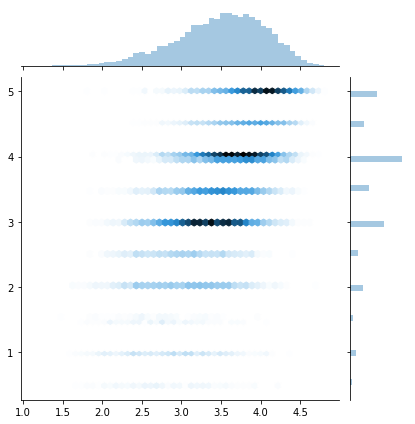

In [87]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [88]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [89]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [15]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [16]:
movie_bias

array([[0.82575],
       [0.97127],
       [1.31398],
       ...,
       [0.32974],
       [0.03886],
       [0.16744]], dtype=float32)

In [17]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [18]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.914487, 'Battlefield Earth (2000)'),
 (-0.74318004, 'Speed 2: Cruise Control (1997)'),
 (-0.7169711, 'Wild Wild West (1999)'),
 (-0.69821966, 'Super Mario Bros. (1993)'),
 (-0.69475657, 'Anaconda (1997)'),
 (-0.6408861, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6398248, 'Inspector Gadget (1999)'),
 (-0.62747866, 'Flintstones, The (1994)'),
 (-0.607285, 'Congo (1995)'),
 (-0.6043957, 'Haunting, The (1999)'),
 (-0.60006714, 'Karate Kid, Part III, The (1989)'),
 (-0.5806055, 'Avengers, The (1998)'),
 (-0.5790544, 'Dungeons & Dragons (2000)'),
 (-0.57736504, 'Jaws 3-D (1983)'),
 (-0.57587194, 'Police Academy 4: Citizens on Patrol (1987)')]

In [19]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.914487, 'Battlefield Earth (2000)'),
 (-0.74318004, 'Speed 2: Cruise Control (1997)'),
 (-0.7169711, 'Wild Wild West (1999)'),
 (-0.69821966, 'Super Mario Bros. (1993)'),
 (-0.69475657, 'Anaconda (1997)'),
 (-0.6408861, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6398248, 'Inspector Gadget (1999)'),
 (-0.62747866, 'Flintstones, The (1994)'),
 (-0.607285, 'Congo (1995)'),
 (-0.6043957, 'Haunting, The (1999)'),
 (-0.60006714, 'Karate Kid, Part III, The (1989)'),
 (-0.5806055, 'Avengers, The (1998)'),
 (-0.5790544, 'Dungeons & Dragons (2000)'),
 (-0.57736504, 'Jaws 3-D (1983)'),
 (-0.57587194, 'Police Academy 4: Citizens on Patrol (1987)')]

In [20]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3139778, 'Shawshank Redemption, The (1994)'),
 (1.1446236, 'Godfather, The (1972)'),
 (1.0800053, 'Usual Suspects, The (1995)'),
 (1.0003818, "Schindler's List (1993)"),
 (0.9712748, 'Pulp Fiction (1994)'),
 (0.9239458, 'To Kill a Mockingbird (1962)'),
 (0.9057478, 'Godfather: Part II, The (1974)'),
 (0.90065944, '12 Angry Men (1957)'),
 (0.8783233, 'Fargo (1996)'),
 (0.8720551, 'Silence of the Lambs, The (1991)'),
 (0.846513, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.8446781, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.8413634, 'American Beauty (1999)'),
 (0.8331065, 'Matrix, The (1999)'),
 (0.832712, 'North by Northwest (1959)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [21]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [23]:
movie_pca.shape

(3, 3000)

In [24]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [25]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07547401, 'Fargo (1996)'),
 (0.07219769, 'Kill Bill: Vol. 1 (2003)'),
 (0.071951486, 'Chinatown (1974)'),
 (0.070021376, 'Taxi Driver (1976)'),
 (0.069815524, 'Godfather, The (1972)'),
 (0.068919234, 'Network (1976)'),
 (0.064207725, 'Pulp Fiction (1994)'),
 (0.06390307,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (0.063619755, '2001: A Space Odyssey (1968)'),
 (0.06299246, 'Apocalypse Now (1979)')]

In [26]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.075908005, 'Armageddon (1998)'),
 (-0.062371466, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.055271678, 'Batman Forever (1995)'),
 (-0.054542195, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.054540377, 'Mission: Impossible II (2000)'),
 (-0.05268937, 'Outbreak (1995)'),
 (-0.051817846, 'Coyote Ugly (2000)'),
 (-0.051183797, 'Bio-Dome (1996)'),
 (-0.049815383, 'Psycho (1998)'),
 (-0.049426857, 'Grumpier Old Men (1995)')]

In [27]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [28]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06340686, '8 1/2 (8½) (1963)'),
 (0.04976317, 'Gosford Park (2001)'),
 (0.048386592, 'Space Jam (1996)'),
 (0.046253785, 'Bend It Like Beckham (2002)'),
 (0.046022974, 'Doors, The (1991)'),
 (0.045653537, 'Anaconda (1997)'),
 (0.044171885, 'Dick Tracy (1990)'),
 (0.043478515, 'Judge Dredd (1995)'),
 (0.043297447, 'From Hell (2001)'),
 (0.04317659, 'Postman, The (Postino, Il) (1994)')]

In [29]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10263303, 'Jurassic Park (1993)'),
 (-0.10205969,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.102038324, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.08970032, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.087637804, 'Dark Knight, The (2008)'),
 (-0.0869132, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.08562384, 'X-Men (2000)'),
 (-0.08269079, 'Lethal Weapon (1987)'),
 (-0.081318915, 'Forrest Gump (1994)'),
 (-0.078577206, 'Die Hard (1988)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

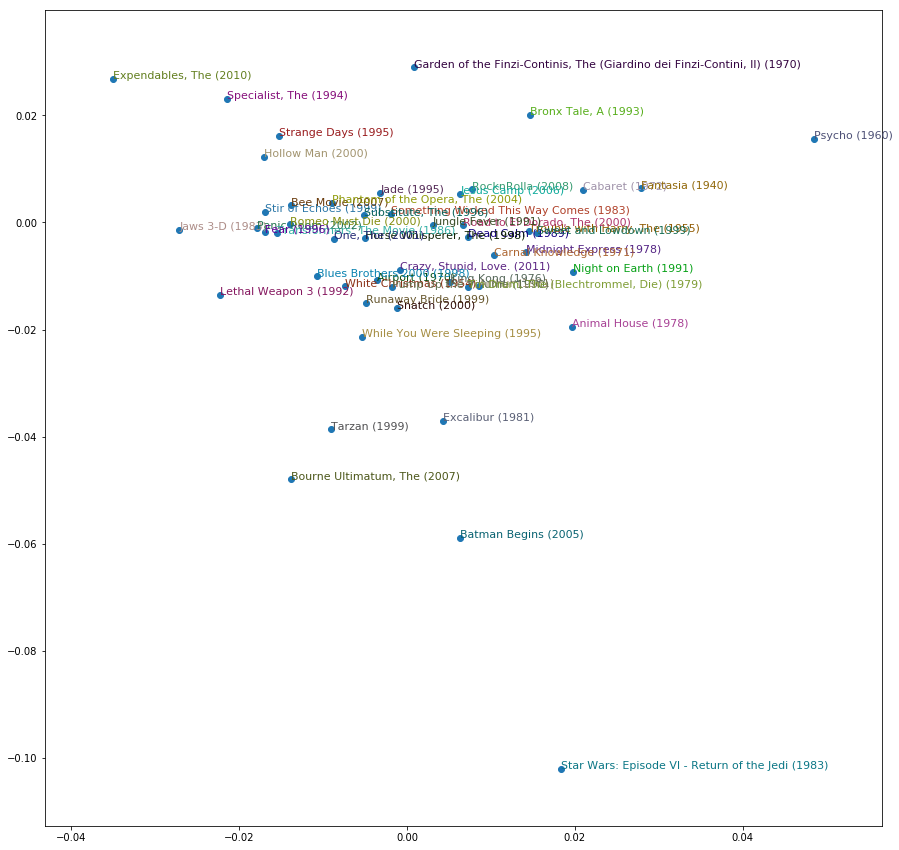

In [30]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [31]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(tensor([[ 1.,  2.],
         [ 3.,  4.]], device='cuda:0'), tensor([[  2.,   2.],
         [ 10.,  10.]], device='cuda:0'))

In [32]:
a*b

tensor([[  2.,   4.],
        [ 30.,  40.]], device='cuda:0')

In [166]:
(a*b).sum(1)

tensor([  6.,  70.], device='cuda:0')

In [34]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [35]:
model=DotProduct()

In [36]:
model(a,b)

tensor([  6.,  70.], device='cuda:0')

### Dot product model

In [90]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [158]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        ret=(u*m).sum(1)
        return ret.view(ret.size()[0],1) 

In [159]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [160]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [161]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [162]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

epoch      trn_loss   val_loss                                 
    0      1.602664   1.635677  
    1      1.06425    1.298748                                 
    2      0.887915   1.226479                                  



[1.2264793167114258]

In [163]:
set_lrs(opt, 0.01)

In [164]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.716369   1.149503  
    1      0.71233    1.137093                                  
    2      0.658079   1.130585                                  



[1.1305849707603455]

### Bias

In [167]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [168]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res.view(-1,1)

In [169]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [170]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.847044   0.839618  
    1      0.82382    0.82015                                   
    2      0.822005   0.807813                                  



[0.8078134284973144]

In [171]:
set_lrs(opt, 1e-2)

In [172]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.742394   0.801958  
    1      0.755982   0.800924                                  
    2      0.727452   0.800246                                  



[0.8002459753036499]

In [174]:
model.parameters

<bound method Module.parameters of EmbeddingDotBias(
  (u): Embedding(671, 50)
  (m): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (mb): Embedding(9066, 1)
)>

In [175]:
preds=predict(model,data.val_dl)

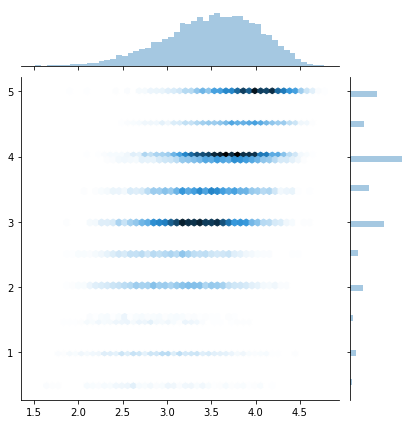

In [177]:
y=data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

### Mini net

In [178]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [179]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [180]:
model.parameters

<bound method Module.parameters of EmbeddingNet(
  (u): Embedding(671, 50)
  (m): Embedding(9066, 50)
  (lin1): Linear(in_features=100, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.5)
)>

In [181]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.883842   0.802773  
    1      0.860118   0.790903                                  
    2      0.814935   0.785071                                  



[0.7850708127975464]

In [182]:
set_lrs(opt, 1e-3)

In [183]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

epoch      trn_loss   val_loss                                  
    0      0.820663   0.787023  
    1      0.754273   0.792145                                  
    2      0.753343   0.793811                                  



[0.793811245059967]

In [200]:
list(model.named_parameters())

[('u.weight', Parameter containing:
  tensor([[ 1.5877e-01,  1.6693e-01,  1.6298e-01,  ..., -1.3603e-01,
            1.4792e-01, -1.3749e-01],
          [-1.6113e-02, -1.4176e-02,  3.5407e-02,  ..., -4.1361e-02,
            3.4596e-02, -2.6658e-02],
          [ 6.2801e-03, -4.4623e-02,  9.2203e-03,  ...,  1.0804e-02,
            7.8504e-02,  9.8452e-03],
          ...,
          [-1.2641e-02,  2.4620e-02, -4.5483e-04,  ..., -3.0201e-02,
           -1.3212e-02, -3.2194e-02],
          [-1.1395e-02, -9.1396e-02,  2.3600e-02,  ..., -1.5034e-03,
            2.8966e-02,  3.5116e-02],
          [ 1.6446e-02,  5.2546e-03,  9.9059e-03,  ...,  1.2919e-02,
            1.7462e-02,  4.7270e-02]], device='cuda:0')),
 ('m.weight', Parameter containing:
  tensor([[ 2.3591e-02, -5.3747e-02,  6.6707e-02,  ..., -7.6216e-03,
           -2.5696e-02, -3.3680e-02],
          [-3.8933e-02,  6.7154e-03, -2.9672e-02,  ...,  1.2938e-02,
            5.8942e-02,  7.3863e-02],
          [-3.6149e-02,  2.2107e-02, 